In [1]:
### Can't plot in BNG, because tilemapbase just uses WM (and this is needed to supply basemap)
# Can plot without a basemap though

In [6]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from warnings import simplefilter
warnings.filterwarnings("ignore", category =UserWarning,)

from pyproj import Transformer
import numpy as np
import pandas as pd
import iris
import glob
import sys
import os
import cartopy.crs as ccrs
import itertools
from scipy import spatial
import numpy.ma as ma
import tilemapbase
import iris.plot as iplt
from math import cos, radians
import geopandas as gpd
from shapely.geometry import Polygon

from Identify_Events_Functions import *

In [2]:
# Set up path to root directory
root_fp = "/nfs/a319/gy17m2a/PhD/"
os.chdir(root_fp)

sys.path.insert(0, root_fp + 'Scripts/GlobalFunctions')
from Spatial_plotting_functions import *
from Spatial_geometry_functions import *

### Get model data: 30 mins data for one ensemble member 2001-2019

In [16]:
filenames = []
em = 'bc005'
in_jja=iris.Constraint(time=lambda cell: 6 <= cell.point.month <= 8)

for yr in range(2001,2020):
    general_filename = f'/nfs/a319/gy17m2a/PhD/ProcessedData/TimeSeries/UKCP18_every30mins/2.2km/2002_2020/{em}/{yr}_maskedcube.nc'
    filenames.append(general_filename)
filenames    

# ### Load in the data
monthly_cubes_list = iris.load(filenames, in_jja)
print(len(monthly_cubes_list))    
model_cube = monthly_cubes_list.concatenate_cube()   

### Get gauge data

In [4]:
# Replace 'your_file_path.txt' with the path to your text file
file_path = '/nfs/a319/gy17m2a/PhD/datadir/RainGauge/interarrival_thresholds_CDD_noMissing.txt'

# Read the CSV data into a DataFrame
tbo_vals = pd.read_csv('/nfs/a319/gy17m2a/PhD/datadir/RainGauge/interarrival_thresholds_CDD_noMissing.txt')

gauge1 = tbo_vals.iloc[1:2]
gauge1['Lat'].values[0]
gauge1['Critical_interarrival_time']

1    9.0
Name: Critical_interarrival_time, dtype: float64

### Find grid cell containing the gauge1 (needs BNG version because of projection issues)

In [7]:
general_filename = f'/nfs/a319/gy17m2a/PhD/datadir/UKCP18_every30mins/2.2km_bng/{em}/2002_2020/bng_{em}a.pr200508*'
cube = iris.load(general_filename)[0]
cube_onets = cube[1,:,:]
closest_point, idx_2d = find_position_obs(cube_onets,gauge1['Lat'].values[0], gauge1['Lon'].values[0] )

### Get model data just for the cell with the gauge inside it

In [9]:
# data = model_cube[:,89,340].data
# df= pd.DataFrame({'precipitation':data})

# Find independent rainfall events for the grid cell

### Extract Tb0 for this gauge (from Roberto's dataset)

In [8]:
Tb0 = gauge1['Critical_interarrival_time'].values[0]

## Convert to functions and apply to each year of the data individually
What this does:  
    -- For each duration it finds the timeseries in each year which produces the maximum value   
    -- Saves these to a list  
    -- Create a dictionary containing durations as keys, and lists of AMAX producing timeseries as the items  
    
    
THINGS TO CONSIDER:  
-- Are we just looking at the timeseries which produced the AMAX at that duration, or the whole event?  
-- Do we also need to loop across EMs?

In [18]:
yr = 2003
# Get cube for this year, at the cell containing the gauge
general_filename = f'/nfs/a319/gy17m2a/PhD/ProcessedData/TimeSeries/UKCP18_every30mins/2.2km/2002_2020/{em}/{yr}_maskedcube.nc'
cube = iris.load(general_filename)[0]
# This gauge
data = cube[:,89,340].data
# Data as dataframe
df= pd.DataFrame({'precipitation (mm/hr)':data})
# New precipitation accumulation column
df['precipitation (mm)'] = df['precipitation (mm/hr)']/2

### Other method

In [22]:
def find_rainfall_core(df, duration, Tb0):    

    window_length= int(duration*2)

    df['is_dry'] = df['precipitation (mm)'] < 0.1
    # Calculate the rolling sum of precipitation for each duration length window
    df['Rolling_Sum'] = df['precipitation (mm)'].rolling(window=window_length).sum()

    # Find the index of the maximum total rainfall within a 2-hour window
    max_rainfall_end_index = df['Rolling_Sum'].idxmax()

    # Find the position of max_rainfall_end_index in the DataFrame's index
    max_rainfall_end_pos = df.index.get_loc(max_rainfall_end_index)

    # Calculate the start position of the 2-hour window with the most rainfall
    # This accounts for 3 periods before the max index, as the max index is inclusive
    max_rainfall_start_pos = max(0, max_rainfall_end_pos - window_length)  # Ensure it doesn't go below the DataFrame's range

    # Extract the 2-hour window using iloc
    max_rainfall_window = df.iloc[max_rainfall_start_pos:max_rainfall_end_pos].copy()

    # Check it's one independent event (e.g. doesnt contain a dry period longer than Tb0)
    max_rainfall_window['consecutive_dry'] = 0

    # Start the count of consecutive dry periods
    consecutive_dry_count = 0

    # # Iterate through the DataFrame rows to count consecutive dry periods, excluding the current row
    # max_rainfall_window.reset_index(inplace=True, drop=True)
    for i in range(1, len(max_rainfall_window)):
        if max_rainfall_window.at[max_rainfall_window.first_valid_index()+i - 1, 'is_dry']:
            consecutive_dry_count += 1
        else:
            consecutive_dry_count = 0
        max_rainfall_window.at[max_rainfall_window.first_valid_index()+i, 'consecutive_dry'] = consecutive_dry_count

    if np.nanmax(max_rainfall_window['consecutive_dry'])>Tb0*2:
        print('2 events')
    return max_rainfall_window

In [24]:
rainfall_core = find_rainfall_core(df, duration=20, Tb0 = Tb0)
# rainfall_core_after_search1 = search1(df, rainfall_core)
# rainfall_core_after_search2 = search2(df, rainfall_core_after_search1)
# rainfall_core_after_search3 = search2(df, rainfall_core_after_search2)
rainfall_core

2 events


,precipitation (mm/hr),precipitation (mm),is_dry,Rolling_Sum,consecutive_dry
2302,1.836392e-08,9.181959e-09,True,15.040809,0
2303,3.095080e-06,1.547540e-06,True,15.040811,1
2304,6.159894e-07,3.079947e-07,True,15.040811,2
2305,3.303463e-07,1.651731e-07,True,15.040810,3
2306,1.580150e-06,7.900751e-07,True,15.040810,4
2307,2.268638e-05,1.134319e-05,True,15.040817,5
2308,1.889906e-04,9.449532e-05,True,15.040907,6
2309,8.231617e-05,4.115808e-05,True,15.040946,7
2310,3.235364e-06,1.617682e-06,True,15.040947,8
2311,1.060043e-05,5.300215e-06,True,15.040949,9


### ???

In [164]:
# # Dictionary to store results for all different durations
# # all_durations = {}

# for duration in [2,6,8,10,12,14]:
#     this_duration_ls =[]
#     for yr in range(2001,2020):
#         print(yr)
#         # Get cube for this year, at the cell containing the gauge
#         general_filename = f'/nfs/a319/gy17m2a/PhD/ProcessedData/TimeSeries/UKCP18_every30mins/2.2km/2002_2020/{em}/{yr}_maskedcube.nc'
#         cube = iris.load(general_filename)[0]
#         # This gauge
#         data = cube[:,89,340].data
#         # Data as dataframe
#         df= pd.DataFrame({'precipitation':data})
#         # Find independent events
#         rainfall_events = find_independent_events(df, Tb0)
#         print(len(rainfall_events))
#         # Find event with maximum rainfall for this duration
#         max_val, max_df, max_idx = find_max_for_this_duration(rainfall_events, duration = duration)
#         # Add to list for this duration
#         this_duration_ls.append(max_df)
#     # Add to dict
#     all_durations[duration] = this_duration_ls

## Check plotting for patterns
### THIS CURRENTLY DOESNT MAKE LOADS OF SENSE AS THE EVENTS AREN'T ALL THE SAME LENGTH

In [ ]:
### PLotting all events, not just of a particular duration (doesnt make sense as they are all different lengths)

In [98]:
# # this_duration_ls[0]["precipitation"].sum()
# plt.figure(figsize=(12, 6))
# for duration in [4]:
#     this_duration_ls =[]
#     for yr in range(2001,2003):
#         print(yr)
#         # Get cube for this year, at the cell containing the gauge
#         general_filename = f'/nfs/a319/gy17m2a/PhD/ProcessedData/TimeSeries/UKCP18_every30mins/2.2km/2002_2020/{em}/{yr}_maskedcube.nc'
#         cube = iris.load(general_filename)[0]
#         data = cube[:,89,340].data
#         df= pd.DataFrame({'precipitation':data})

#         # Find independent events
#         rainfall_events = find_independent_events(df, Tb0)
#         for rainfall_event in rainfall_events:
#             rainfall_event['event_data'].reset_index(inplace=True, drop=True)
#             plt.plot(rainfall_event['event_data'].index, rainfall_event['event_data']['precipitation'], marker='o', linestyle='-')

# plt.title('Precipitation Over Time')
# plt.xlabel('Time (30-minute intervals)')
# plt.ylabel('Precipitation (mm/hr)')
# plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability
# plt.grid(True)  # Optional: Adds a grid for easier visualization
# plt.tight_layout()  # Adjusts subplot params so that the subplot(s) fits in to the figure area
# plt.show()

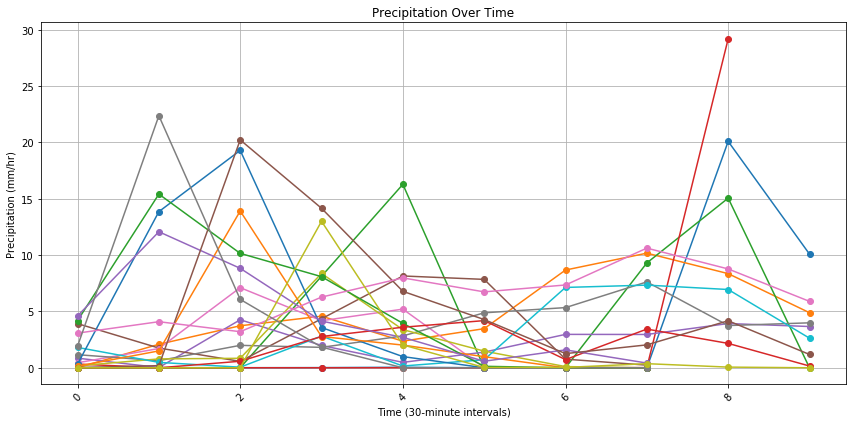

In [86]:
# this_duration_ls[0]["precipitation"].sum()
plt.figure(figsize=(12, 6))
for rainfall_event in all_durations[4]:
    rainfall_event.reset_index(inplace=True, drop=True)
    # Plotting
    plt.plot(rainfall_event.index, rainfall_event['precipitation'], marker='o', linestyle='-')

plt.title('Precipitation Over Time')
plt.xlabel('Time (30-minute intervals)')
plt.ylabel('Precipitation (mm/hr)')
plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability
plt.grid(True)  # Optional: Adds a grid for easier visualization
plt.tight_layout()  # Adjusts subplot params so that the subplot(s) fits in to the figure area
plt.show()

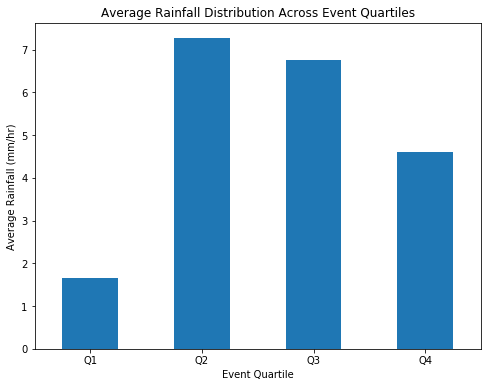

In [103]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# Assuming event_list is your list of DataFrames, each with 'precipitation' for 30-min intervals

# Step 1: Normalize Each Event to 4 intervals (quartiles)
normalized_events = []
for event_df in all_durations[2]:
    # Create a normalized scale (0 to 1) for the event duration
    x_old = np.linspace(0, 1, num=len(event_df))
    y_old = event_df['precipitation'].values
    # Create a function to interpolate rainfall data to 4 points (quartiles)
    f = interp1d(x_old, y_old, kind='linear')
    x_new = np.linspace(0, 1, num=4)  # Target 4 intervals for normalization
    y_new = f(x_new)  # Interpolated rainfall values
    normalized_events.append(y_new)

# Step 2: Aggregate Rainfall Data Across Events
# Convert list of arrays to a DataFrame for easy calculation
agg_df = pd.DataFrame(normalized_events, columns=['Q1', 'Q2', 'Q3', 'Q4'])
aggregate_rainfall = agg_df.mean()

# Step 3: Analyze the Temporal Distribution
# Plotting the aggregated rainfall data
plt.figure(figsize=(8, 6))
aggregate_rainfall.plot(kind='bar')
plt.title('Average Rainfall Distribution Across Event Quartiles')
plt.xlabel('Event Quartile')
plt.ylabel('Average Rainfall (mm/hr)')
plt.xticks(rotation=0)
plt.show()


In [120]:
all_durations.keys()

dict_keys([4, 2, 6, 8, 10, 12, 14])

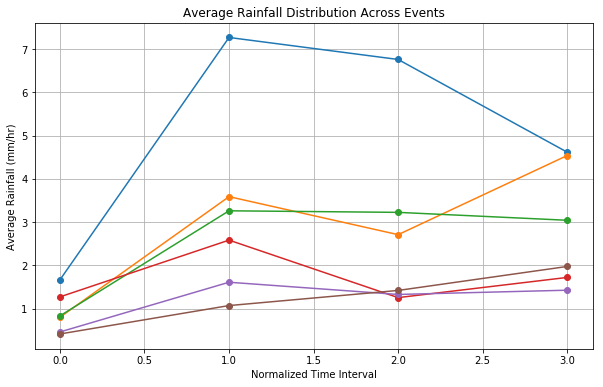

In [123]:
n_breaks = 4

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# Example setup for 'event_list', a list of DataFrames
# Each DataFrame represents a rainfall event with 'precipitation' for each 30-minute interval

# Placeholder for your actual event list
event_list = [pd.DataFrame({'precipitation': np.random.rand(np.random.randint(8, 12)) * np.random.randint(1, 4)}) for _ in range(10)]


plt.figure(figsize=(10, 6))

for duration in [2, 4,6, 8,10,12]:
    # Normalize Each Event to 8 intervals
    normalized_events = []
    for event_df in all_durations[duration]:
        # Interpolate or directly split the precipitation data of each event to 8 intervals
        if len(event_df) > n_breaks:
            x_old = np.linspace(0, 1, num=len(event_df))
            y_old = event_df['precipitation'].values
            f = interp1d(x_old, y_old, kind='linear')
            x_new = np.linspace(0, 1, num=n_breaks)  # Target 8 intervals for normalization
            y_new = f(x_new)  # Interpolated rainfall values
        else:
            y_new = event_df['precipitation'].values  # No need to interpolate if already 8 steps
        normalized_events.append(y_new)

    # Aggregate Rainfall Data Across Events
    agg_df = pd.DataFrame(normalized_events)
    aggregate_rainfall = agg_df.mean()

    # Analyze the Temporal Distribution

    aggregate_rainfall.plot(marker='o', linestyle='-')
plt.title('Average Rainfall Distribution Across Events')
plt.xlabel('Normalized Time Interval')
plt.ylabel('Average Rainfall (mm/hr)')
# plt.xticks(ticks=np.arange(8), labels=[f'Part {i+1}' for i in range(8)])
plt.grid(True)
plt.show()
